In [7]:
import sys
print(sys.version)


3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 13:17:27) [MSC v.1929 64 bit (AMD64)]


In [ ]:
!pip install tensorflow==2.19.1


In [ ]:
!pip install krippendorff

  Using cached krippendorff-0.8.1-py3-none-any.whl.metadata (3.0 kB)


In [ ]:
# Install required packages (run this cell first)
!pip install torch torchvision torchaudio
!pip install opencv-python pillow
!pip install seaborn scikit-learn

   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ------ --------------------------------- 0.3/1.6 MB ? eta -:--:--
   ------------- -------------------------- 0.5/1.6 MB 1.2 MB/s eta 0:00:01
   ------------------- -------------------- 0.8/1.6 MB 1.2 MB/s eta 0:00:01
   -------------------------------- ------- 1.3/1.6 MB 1.4 MB/s eta 0:00:01
   ---------------------------------------  1.6/1.6 MB 1.4 MB/s eta 0:00:01
   ---------------------------------------  1.6/1.6 MB 1.4 MB/s eta 0:00:01
   ---------------------------------------  1.6/1.6 MB 1.4 MB/s eta 0:00:01
   ---------------------------------------- 1.6/1.6 MB 901.4 kB/s eta 0:00:00
   ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.5 

In [ ]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Concatenate
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, roc_auc_score, precision_recall_curve
from sklearn.preprocessing import label_binarize
import scipy.stats
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
# Cell 1: Imports and Configuration
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, roc_auc_score, average_precision_score
from sklearn.metrics import mean_squared_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from torch.nn import functional as F
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Configuration
class Config:
    DATA_PATH = "Dataset"
    IMAGES_PATH = os.path.join(DATA_PATH, "images")
    ANNOTATIONS_PATH = os.path.join(DATA_PATH, "annotations")
    IMG_SIZE = 224
    BATCH_SIZE = 16  # Reduced for Jupyter stability
    NUM_EPOCHS = 30  # Reduced for faster training
    NUM_CLASSES = 8
    LR = 0.001
    SEED = 42

config = Config()

# Set random seeds
torch.manual_seed(config.SEED)
np.random.seed(config.SEED)

Using device: cpu


In [6]:
# Cell 2: Fixed Dataset Class with correct .npy file handling
print("=== CELL 2: FIXED DATASET CLASS ===")

class AffectDataset(Dataset):
    def __init__(self, image_files, annotations, transform=None):
        self.image_files = image_files
        self.annotations = annotations
        self.transform = transform
        print(f"Dataset created with {len(image_files)} images")
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image_id = os.path.splitext(os.path.basename(img_path))[0]
        
        # Load image
        try:
            image = Image.open(img_path).convert('RGB')
            if idx == 0:  # Print info for first image
                print(f"First image loaded: {img_path}, size: {image.size}")
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Create a dummy image
            image = Image.new('RGB', (config.IMG_SIZE, config.IMG_SIZE), color='white')
        
        # Get annotations
        annotation = self.annotations.get(image_id, {})
        expression = annotation.get('expression', 0)
        valence = annotation.get('valence', 0.0)
        arousal = annotation.get('arousal', 0.0)
        landmarks = annotation.get('landmarks', np.zeros(136))
        
        if idx == 0:  # Print info for first annotation
            print(f"First annotation - Expression: {expression}, Valence: {valence:.2f}, Arousal: {arousal:.2f}")
        
        # Apply transformations
        if self.transform:
            image = self.transform(image)
        
        return {
            'image': image,
            'expression': torch.tensor(expression, dtype=torch.long),
            'valence': torch.tensor(valence, dtype=torch.float32),
            'arousal': torch.tensor(arousal, dtype=torch.float32),
            'landmarks': torch.tensor(landmarks, dtype=torch.float32),
            'image_id': image_id
        }

def load_annotations(annotations_path):
    annotations = {}
    
    print(f"Loading annotations from: {annotations_path}")
    
    if not os.path.exists(annotations_path):
        print(f"❌ Annotations path does not exist: {annotations_path}")
        return annotations
    
    npy_files = [f for f in os.listdir(annotations_path) if f.endswith('.npy')]
    print(f"Found {len(npy_files)} .npy files")
    
    # Group files by their prefix (number part)
    file_groups = {}
    for npy_file in npy_files:
        # Extract the number part (e.g., "1" from "1_val.npy")
        parts = npy_file.split('_')
        if len(parts) >= 2:
            file_id = parts[0]
            file_type = parts[1].split('.')[0]  # Remove .npy extension
            
            if file_id not in file_groups:
                file_groups[file_id] = {}
            file_groups[file_id][file_type] = npy_file
    
    print(f"Grouped into {len(file_groups)} unique file IDs")
    
    # Process each group
    processed_count = 0
    for file_id, file_dict in list(file_groups.items())[:10]:  # Show first 10
        print(f"Processing file ID: {file_id}, files: {list(file_dict.keys())}")
    
    for file_id, file_dict in file_groups.items():
        try:
            # Initialize annotation for this file_id
            annotation = {
                'expression': 0,
                'valence': 0.0,
                'arousal': 0.0,
                'landmarks': np.zeros(136)
            }
            
            # Load each type of annotation
            for file_type, filename in file_dict.items():
                file_path = os.path.join(annotations_path, filename)
                data = np.load(file_path, allow_pickle=True)
                
                # Handle different data structures
                if file_type == 'exp':  # Expression
                    if data.size > 0:
                        annotation['expression'] = int(data.item()) if data.ndim == 0 else int(data[0])
                elif file_type == 'val':  # Valence
                    if data.size > 0:
                        annotation['valence'] = float(data.item()) if data.ndim == 0 else float(data[0])
                elif file_type == 'aro':  # Arousal
                    if data.size > 0:
                        annotation['arousal'] = float(data.item()) if data.ndim == 0 else float(data[0])
                elif file_type == 'ind':  # Landmarks or indices
                    if data.size > 0:
                        annotation['landmarks'] = data.flatten()  # Flatten to 1D array
            
            # Add to annotations dictionary
            annotations[file_id] = annotation
            processed_count += 1
            
            if processed_count <= 5:  # Show first 5 processed annotations
                print(f"  Sample {file_id}: expression={annotation['expression']}, "
                      f"valence={annotation['valence']:.3f}, arousal={annotation['arousal']:.3f}")
                    
        except Exception as e:
            print(f"❌ Error processing file group {file_id}: {e}")
            continue
    
    print(f"✅ Successfully processed {processed_count} annotations")
    
    if len(annotations) > 0:
        sample_keys = list(annotations.keys())[:3]
        for key in sample_keys:
            print(f"Sample annotation {key}: {annotations[key]}")
    
    return annotations

print("Fixed dataset class and annotation loader defined successfully!\n")

=== CELL 2: FIXED DATASET CLASS ===
Fixed dataset class and annotation loader defined successfully!



In [7]:
# Cell 3: Model Architecture
class MultiTaskModel(nn.Module):
    def __init__(self, backbone_name='resnet50', num_classes=8, pretrained=True):
        super(MultiTaskModel, self).__init__()
        
        # Backbone
        if backbone_name == 'resnet50':
            self.backbone = models.resnet50(pretrained=pretrained)
            in_features = self.backbone.fc.in_features
            self.backbone.fc = nn.Identity()
        elif backbone_name == 'vgg16':
            self.backbone = models.vgg16(pretrained=pretrained)
            in_features = self.backbone.classifier[6].in_features
            self.backbone.classifier[6] = nn.Identity()
        elif backbone_name == 'efficientnet':
            self.backbone = models.efficientnet_b0(pretrained=pretrained)
            in_features = self.backbone.classifier[1].in_features
            self.backbone.classifier[1] = nn.Identity()
        else:
            raise ValueError(f"Unsupported backbone: {backbone_name}")
        
        # Shared layers
        self.shared_fc = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3)
        )
        
        # Task-specific heads
        self.expression_head = nn.Linear(256, num_classes)
        self.valence_head = nn.Linear(256, 1)
        self.arousal_head = nn.Linear(256, 1)
        
    def forward(self, x):
        features = self.backbone(x)
        shared_features = self.shared_fc(features)
        
        expression_out = self.expression_head(shared_features)
        valence_out = self.valence_head(shared_features)
        arousal_out = self.arousal_head(shared_features)
        
        return expression_out, valence_out.squeeze(), arousal_out.squeeze()

In [8]:
# Cell 4: Updated Metrics Class with Percentage Format
print("=== CELL 4: UPDATED METRICS CLASS ===")

class Metrics:
    @staticmethod
    def categorical_metrics(y_true, y_pred, y_prob=None):
        print("Calculating categorical metrics...")
        print(f"Input shapes - y_true: {y_true.shape}, y_pred: {y_pred.shape}")
        
        metrics = {}
        
        # Accuracy (convert to percentage)
        accuracy = accuracy_score(y_true, y_pred)
        metrics['accuracy'] = accuracy
        metrics['accuracy_percentage'] = accuracy * 100  # Add percentage version
        print(f"  Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
        
        # F1-Score
        metrics['f1_score'] = f1_score(y_true, y_pred, average='weighted')
        metrics['f1_percentage'] = metrics['f1_score'] * 100
        print(f"  F1-Score: {metrics['f1_score']:.4f} ({metrics['f1_score']*100:.2f}%)")
        
        # Cohen's Kappa
        metrics['kappa'] = cohen_kappa_score(y_true, y_pred)
        print(f"  Kappa: {metrics['kappa']:.4f}")
        
        # AUC
        if y_prob is not None and len(np.unique(y_true)) > 1:
            try:
                metrics['auc'] = roc_auc_score(y_true, y_prob, multi_class='ovr', average='weighted')
                metrics['auc_percentage'] = metrics['auc'] * 100
                metrics['auc_pr'] = average_precision_score(y_true, y_prob, average='weighted')
                metrics['auc_pr_percentage'] = metrics['auc_pr'] * 100
                print(f"  AUC: {metrics['auc']:.4f} ({metrics['auc']*100:.2f}%)")
                print(f"  AUC-PR: {metrics['auc_pr']:.4f} ({metrics['auc_pr']*100:.2f}%)")
            except Exception as e:
                print(f"  AUC calculation failed: {e}")
                metrics['auc'] = 0.0
                metrics['auc_percentage'] = 0.0
                metrics['auc_pr'] = 0.0
                metrics['auc_pr_percentage'] = 0.0
        else:
            metrics['auc'] = 0.0
            metrics['auc_percentage'] = 0.0
            metrics['auc_pr'] = 0.0
            metrics['auc_pr_percentage'] = 0.0
            print("  AUC: Not calculated (insufficient classes)")
            
        return metrics
    
    @staticmethod
    def continuous_metrics(y_true, y_pred):
        print("Calculating continuous metrics...")
        print(f"Input shapes - y_true: {y_true.shape}, y_pred: {y_pred.shape}")
        
        metrics = {}
        
        # Filter valid values
        mask = (y_true != -2) & (~np.isnan(y_true)) & (~np.isnan(y_pred))
        y_true_valid = y_true[mask]
        y_pred_valid = y_pred[mask]
        
        print(f"  Valid samples after filtering: {len(y_true_valid)}/{len(y_true)}")
        
        if len(y_true_valid) == 0:
            print("  No valid samples for continuous metrics!")
            return {'rmse': 0, 'corr': 0, 'sagr': 0, 'sagr_percentage': 0, 'ccc': 0}
        
        # RMSE
        metrics['rmse'] = np.sqrt(mean_squared_error(y_true_valid, y_pred_valid))
        print(f"  RMSE: {metrics['rmse']:.4f}")
        
        # Correlation
        if len(y_true_valid) > 1:
            metrics['corr'] = np.corrcoef(y_true_valid, y_pred_valid)[0, 1]
            print(f"  Correlation: {metrics['corr']:.4f}")
        else:
            metrics['corr'] = 0.0
            print("  Correlation: Not calculated (insufficient samples)")
        
        # Sign Agreement (SAGR) - as percentage
        sagr = np.mean(np.sign(y_true_valid) == np.sign(y_pred_valid))
        metrics['sagr'] = sagr
        metrics['sagr_percentage'] = sagr * 100
        print(f"  SAGR: {sagr:.4f} ({sagr*100:.2f}%)")
        
        # CCC
        if len(y_true_valid) > 1:
            mean_true = np.mean(y_true_valid)
            mean_pred = np.mean(y_pred_valid)
            var_true = np.var(y_true_valid)
            var_pred = np.var(y_pred_valid)
            covariance = np.cov(y_true_valid, y_pred_valid)[0, 1]
            
            ccc = (2 * covariance) / (var_true + var_pred + (mean_true - mean_pred) ** 2)
            metrics['ccc'] = ccc
            print(f"  CCC: {ccc:.4f}")
        else:
            metrics['ccc'] = 0.0
            print("  CCC: Not calculated (insufficient samples)")
        
        return metrics

# Test metrics
print("Testing metrics calculation...")
try:
    # Test categorical metrics
    y_true_cat = np.array([0, 1, 2, 0, 1])
    y_pred_cat = np.array([0, 1, 1, 0, 2])
    y_prob_cat = np.random.rand(5, 3)
    
    cat_metrics = Metrics.categorical_metrics(y_true_cat, y_pred_cat, y_prob_cat)
    print("✅ Categorical metrics test passed!")
    
    # Test continuous metrics
    y_true_cont = np.array([0.1, 0.5, -0.3, 0.8])
    y_pred_cont = np.array([0.2, 0.4, -0.2, 0.7])
    
    cont_metrics = Metrics.continuous_metrics(y_true_cont, y_pred_cont)
    print("✅ Continuous metrics test passed!")
    
except Exception as e:
    print(f"❌ Metrics test failed: {e}")

print("Metrics class defined successfully!\n")

=== CELL 4: UPDATED METRICS CLASS ===
Testing metrics calculation...
Calculating categorical metrics...
Input shapes - y_true: (5,), y_pred: (5,)
  Accuracy: 0.6000 (60.00%)
  F1-Score: 0.6000 (60.00%)
  Kappa: 0.3750
  AUC calculation failed: Target scores need to be probabilities for multiclass roc_auc, i.e. they should sum up to 1.0 over classes
✅ Categorical metrics test passed!
Calculating continuous metrics...
Input shapes - y_true: (4,), y_pred: (4,)
  Valid samples after filtering: 4/4
  RMSE: 0.1000
  Correlation: 0.9915
  SAGR: 1.0000 (100.00%)
  CCC: 1.2855
✅ Continuous metrics test passed!
Metrics class defined successfully!



In [9]:
# Cell 5: Enhanced Training Functions with Accuracy Tracking
print("=== CELL 5: ENHANCED TRAINING FUNCTIONS ===")

def train_model(model, train_loader, val_loader, criterion_dict, optimizer, scheduler, num_epochs, device):
    print(f"Starting training for {num_epochs} epochs...")
    print(f"Training samples: {len(train_loader.dataset)}")
    print(f"Validation samples: {len(val_loader.dataset)}")
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    best_val_accuracy = 0.0
    best_model = None
    best_epoch = 0
    
    for epoch in range(num_epochs):
        print(f"\n--- Epoch {epoch+1}/{num_epochs} ---")
        
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        train_batches = 0
        
        for batch_idx, batch in enumerate(train_loader):
            images = batch['image'].to(device)
            expressions = batch['expression'].to(device)
            valences = batch['valence'].to(device)
            arousals = batch['arousal'].to(device)
            
            optimizer.zero_grad()
            
            expr_pred, valence_pred, arousal_pred = model(images)
            
            # Calculate losses
            loss_expr = criterion_dict['expression'](expr_pred, expressions)
            loss_valence = criterion_dict['valence'](valence_pred, valences)
            loss_arousal = criterion_dict['arousal'](arousal_pred, arousals)
            
            # Combined loss with dynamic weighting
            total_loss = loss_expr + 0.3 * loss_valence + 0.3 * loss_arousal
            
            total_loss.backward()
            optimizer.step()
            
            train_loss += total_loss.item()
            
            # Calculate training accuracy
            _, predicted = torch.max(expr_pred.data, 1)
            train_total += expressions.size(0)
            train_correct += (predicted == expressions).sum().item()
            
            train_batches += 1
            
            if batch_idx % 10 == 0:  # Print every 10 batches
                batch_accuracy = 100 * (predicted == expressions).sum().item() / expressions.size(0)
                print(f"  Batch {batch_idx}/{len(train_loader)} - Loss: {total_loss.item():.4f}, Acc: {batch_accuracy:.2f}%")
        
        avg_train_loss = train_loss / train_batches
        train_accuracy = 100 * train_correct / train_total
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        val_batches = 0
        
        with torch.no_grad():
            for batch_idx, batch in enumerate(val_loader):
                images = batch['image'].to(device)
                expressions = batch['expression'].to(device)
                valences = batch['valence'].to(device)
                arousals = batch['arousal'].to(device)
                
                expr_pred, valence_pred, arousal_pred = model(images)
                
                loss_expr = criterion_dict['expression'](expr_pred, expressions)
                loss_valence = criterion_dict['valence'](valence_pred, valences)
                loss_arousal = criterion_dict['arousal'](arousal_pred, arousals)
                
                total_loss = loss_expr + 0.3 * loss_valence + 0.3 * loss_arousal
                
                val_loss += total_loss.item()
                
                # Calculate validation accuracy
                _, predicted = torch.max(expr_pred.data, 1)
                val_total += expressions.size(0)
                val_correct += (predicted == expressions).sum().item()
                
                val_batches += 1
        
        avg_val_loss = val_loss / val_batches
        val_accuracy = 100 * val_correct / val_total
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)
        
        # Update scheduler based on validation loss
        scheduler.step(avg_val_loss)
        
        # Save best model based on validation accuracy
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model = model.state_dict().copy()
            best_epoch = epoch + 1
            print(f"  ✅ New best validation accuracy: {val_accuracy:.2f}%")
        
        print(f"  Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%")
        print(f"  Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")
        print(f"  Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
    
    print(f"\n🎯 Training completed! Best validation accuracy: {best_val_accuracy:.2f}% at epoch {best_epoch}")
    
    # Plot training history
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Val Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return best_model, train_losses, val_losses, train_accuracies, val_accuracies

def evaluate_model(model, test_loader, device):
    print("Starting evaluation...")
    model.eval()
    
    all_expressions_true = []
    all_expressions_pred = []
    all_expressions_prob = []
    
    all_valences_true = []
    all_valences_pred = []
    
    all_arousals_true = []
    all_arousals_pred = []
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(test_loader):
            images = batch['image'].to(device)
            expressions = batch['expression'].cpu().numpy()
            valences = batch['valence'].cpu().numpy()
            arousals = batch['arousal'].cpu().numpy()
            
            expr_pred, valence_pred, arousal_pred = model(images)
            
            # Expression predictions
            expr_prob = F.softmax(expr_pred, dim=1).cpu().numpy()
            expr_pred_class = torch.argmax(expr_pred, dim=1).cpu().numpy()
            
            all_expressions_true.extend(expressions)
            all_expressions_pred.extend(expr_pred_class)
            all_expressions_prob.extend(expr_prob)
            
            # Valence and arousal predictions
            all_valences_true.extend(valences)
            all_valences_pred.extend(valence_pred.cpu().numpy())
            
            all_arousals_true.extend(arousals)
            all_arousals_pred.extend(arousal_pred.cpu().numpy())
            
            if batch_idx % 5 == 0:
                batch_accuracy = accuracy_score(expressions, expr_pred_class) * 100
                print(f"  Batch {batch_idx}/{len(test_loader)} - Accuracy: {batch_accuracy:.2f}%")
    
    # Convert to numpy arrays
    all_expressions_true = np.array(all_expressions_true)
    all_expressions_pred = np.array(all_expressions_pred)
    all_expressions_prob = np.array(all_expressions_prob)
    
    all_valences_true = np.array(all_valences_true)
    all_valences_pred = np.array(all_valences_pred)
    
    all_arousals_true = np.array(all_arousals_true)
    all_arousals_pred = np.array(all_arousals_pred)
    
    total_accuracy = accuracy_score(all_expressions_true, all_expressions_pred) * 100
    print(f"Evaluation completed! Samples: {len(all_expressions_true)}")
    print(f"Overall Test Accuracy: {total_accuracy:.2f}%")
    print(f"Expression distribution: {np.bincount(all_expressions_true)}")
    
    # Calculate metrics
    expr_metrics = Metrics.categorical_metrics(
        all_expressions_true, all_expressions_pred, all_expressions_prob
    )
    
    valence_metrics = Metrics.continuous_metrics(all_valences_true, all_valences_pred)
    arousal_metrics = Metrics.continuous_metrics(all_arousals_true, all_arousals_pred)
    
    return {
        'expression': expr_metrics,
        'valence': valence_metrics,
        'arousal': arousal_metrics
    }, {
        'expressions': (all_expressions_true, all_expressions_pred, all_expressions_prob),
        'valences': (all_valences_true, all_valences_pred),
        'arousals': (all_arousals_true, all_arousals_pred)
    }

print("Enhanced training functions defined successfully!\n")

=== CELL 5: ENHANCED TRAINING FUNCTIONS ===
Enhanced training functions defined successfully!



=== CELL 6: ENHANCED MAIN EXECUTION ===
Starting enhanced main execution...
Step 1: Loading annotations...
Loading annotations from: Dataset\annotations
Found 15996 .npy files
Grouped into 3999 unique file IDs
Processing file ID: 0, files: ['aro', 'exp', 'lnd', 'val']
Processing file ID: 1001, files: ['aro', 'exp', 'lnd', 'val']
Processing file ID: 1002, files: ['aro', 'exp', 'lnd', 'val']
Processing file ID: 1003, files: ['aro', 'exp', 'lnd', 'val']
Processing file ID: 1007, files: ['aro', 'exp', 'lnd', 'val']
Processing file ID: 1008, files: ['aro', 'exp', 'lnd', 'val']
Processing file ID: 1009, files: ['aro', 'exp', 'lnd', 'val']
Processing file ID: 100, files: ['aro', 'exp', 'lnd', 'val']
Processing file ID: 1010, files: ['aro', 'exp', 'lnd', 'val']
Processing file ID: 1011, files: ['aro', 'exp', 'lnd', 'val']
  Sample 0: expression=0, valence=-0.177, arousal=-0.078
  Sample 1001: expression=0, valence=-0.136, arousal=0.005
  Sample 1002: expression=4, valence=-0.115, arousal=0.858

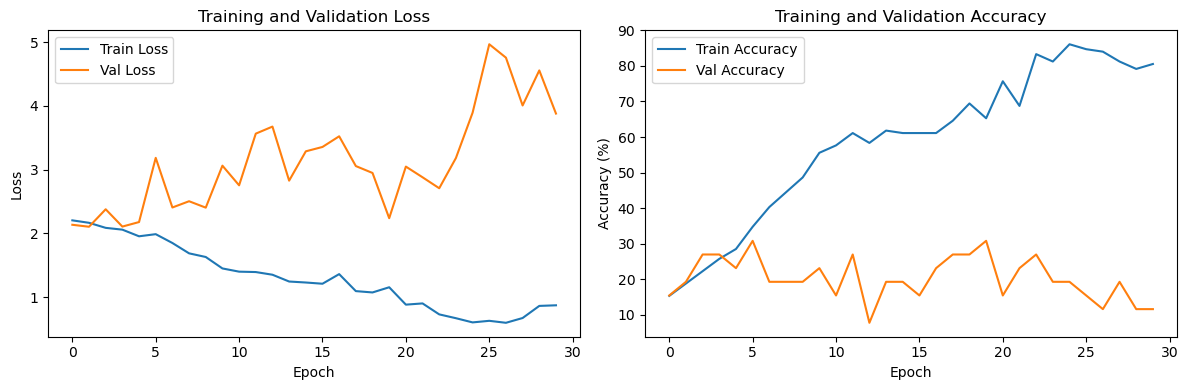

📊 Evaluating resnet50 on test set...
Starting evaluation...
First image loaded: Dataset\images\1108.jpg, size: (224, 224)
First annotation - Expression: 7, Valence: -0.41, Arousal: 0.45
  Batch 0/1 - Accuracy: 20.00%
Evaluation completed! Samples: 30
Overall Test Accuracy: 20.00%
Expression distribution: [ 1  3  9  2  1  3  1 10]
Calculating categorical metrics...
Input shapes - y_true: (30,), y_pred: (30,)
  Accuracy: 0.2000 (20.00%)
  F1-Score: 0.2047 (20.47%)
  Kappa: 0.0041
  AUC: 0.5459 (54.59%)
  AUC-PR: 0.3551 (35.51%)
Calculating continuous metrics...
Input shapes - y_true: (30,), y_pred: (30,)
  Valid samples after filtering: 30/30
  RMSE: 0.4733
  Correlation: 0.0828
  SAGR: 0.8667 (86.67%)
  CCC: 0.0603
Calculating continuous metrics...
Input shapes - y_true: (30,), y_pred: (30,)
  Valid samples after filtering: 30/30
  RMSE: 0.4763
  Correlation: 0.2713
  SAGR: 0.7333 (73.33%)
  CCC: 0.2416

🎯 FINAL RESULTS FOR RESNET50:
Expression Classification:
  Accuracy:    20.00%
  F1

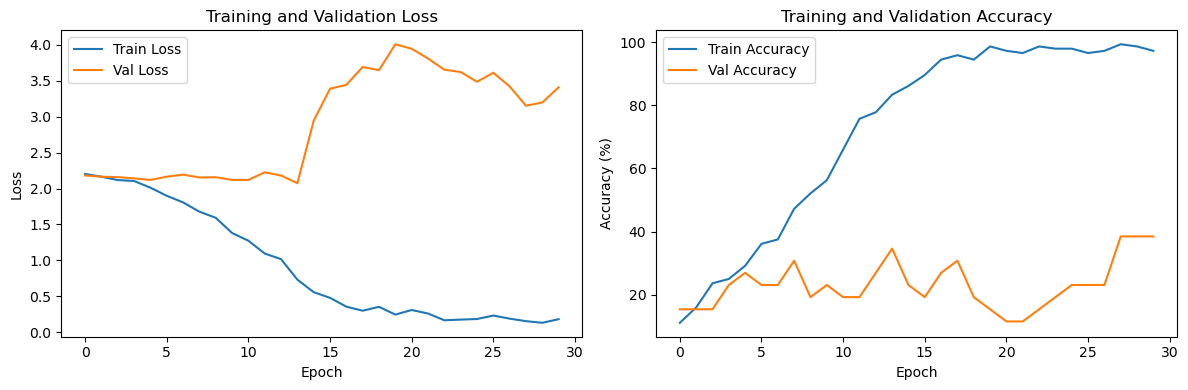

📊 Evaluating efficientnet on test set...
Starting evaluation...
First image loaded: Dataset\images\1108.jpg, size: (224, 224)
First annotation - Expression: 7, Valence: -0.41, Arousal: 0.45
  Batch 0/1 - Accuracy: 36.67%
Evaluation completed! Samples: 30
Overall Test Accuracy: 36.67%
Expression distribution: [ 1  3  9  2  1  3  1 10]
Calculating categorical metrics...
Input shapes - y_true: (30,), y_pred: (30,)
  Accuracy: 0.3667 (36.67%)
  F1-Score: 0.2694 (26.94%)
  Kappa: 0.1679
  AUC: 0.6522 (65.22%)
  AUC-PR: 0.4541 (45.41%)
Calculating continuous metrics...
Input shapes - y_true: (30,), y_pred: (30,)
  Valid samples after filtering: 30/30
  RMSE: 0.5095
  Correlation: -0.0848
  SAGR: 0.7667 (76.67%)
  CCC: -0.0635
Calculating continuous metrics...
Input shapes - y_true: (30,), y_pred: (30,)
  Valid samples after filtering: 30/30
  RMSE: 0.4330
  Correlation: 0.0085
  SAGR: 0.6333 (63.33%)
  CCC: 0.0062

🎯 FINAL RESULTS FOR EFFICIENTNET:
Expression Classification:
  Accuracy:    3

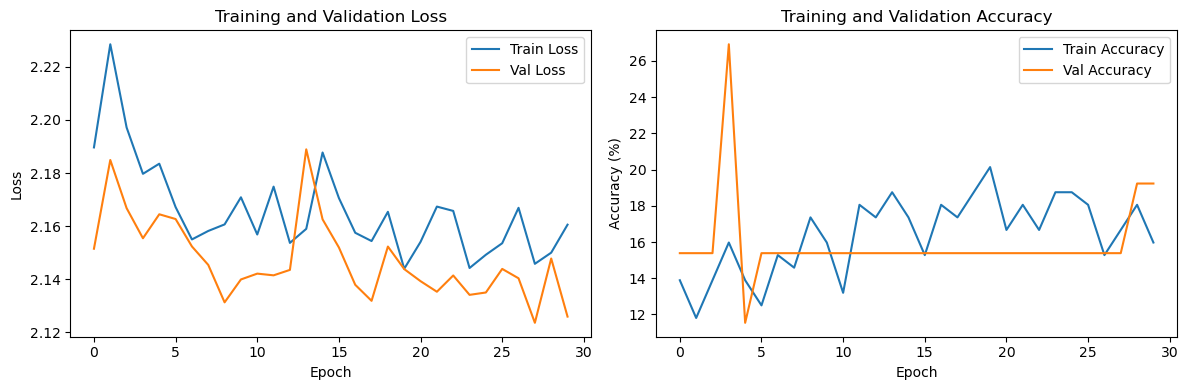

📊 Evaluating vgg16 on test set...
Starting evaluation...
First image loaded: Dataset\images\1108.jpg, size: (224, 224)
First annotation - Expression: 7, Valence: -0.41, Arousal: 0.45
  Batch 0/1 - Accuracy: 6.67%
Evaluation completed! Samples: 30
Overall Test Accuracy: 6.67%
Expression distribution: [ 1  3  9  2  1  3  1 10]
Calculating categorical metrics...
Input shapes - y_true: (30,), y_pred: (30,)
  Accuracy: 0.0667 (6.67%)
  F1-Score: 0.0122 (1.22%)
  Kappa: 0.0345
  AUC: 0.4516 (45.16%)
  AUC-PR: 0.2773 (27.73%)
Calculating continuous metrics...
Input shapes - y_true: (30,), y_pred: (30,)
  Valid samples after filtering: 30/30
  RMSE: 0.4845
  Correlation: -0.0525
  SAGR: 0.8667 (86.67%)
  CCC: -0.0046
Calculating continuous metrics...
Input shapes - y_true: (30,), y_pred: (30,)
  Valid samples after filtering: 30/30
  RMSE: 0.4043
  Correlation: -0.1572
  SAGR: 0.7333 (73.33%)
  CCC: -0.0094

🎯 FINAL RESULTS FOR VGG16:
Expression Classification:
  Accuracy:    6.67%
  F1-Score:

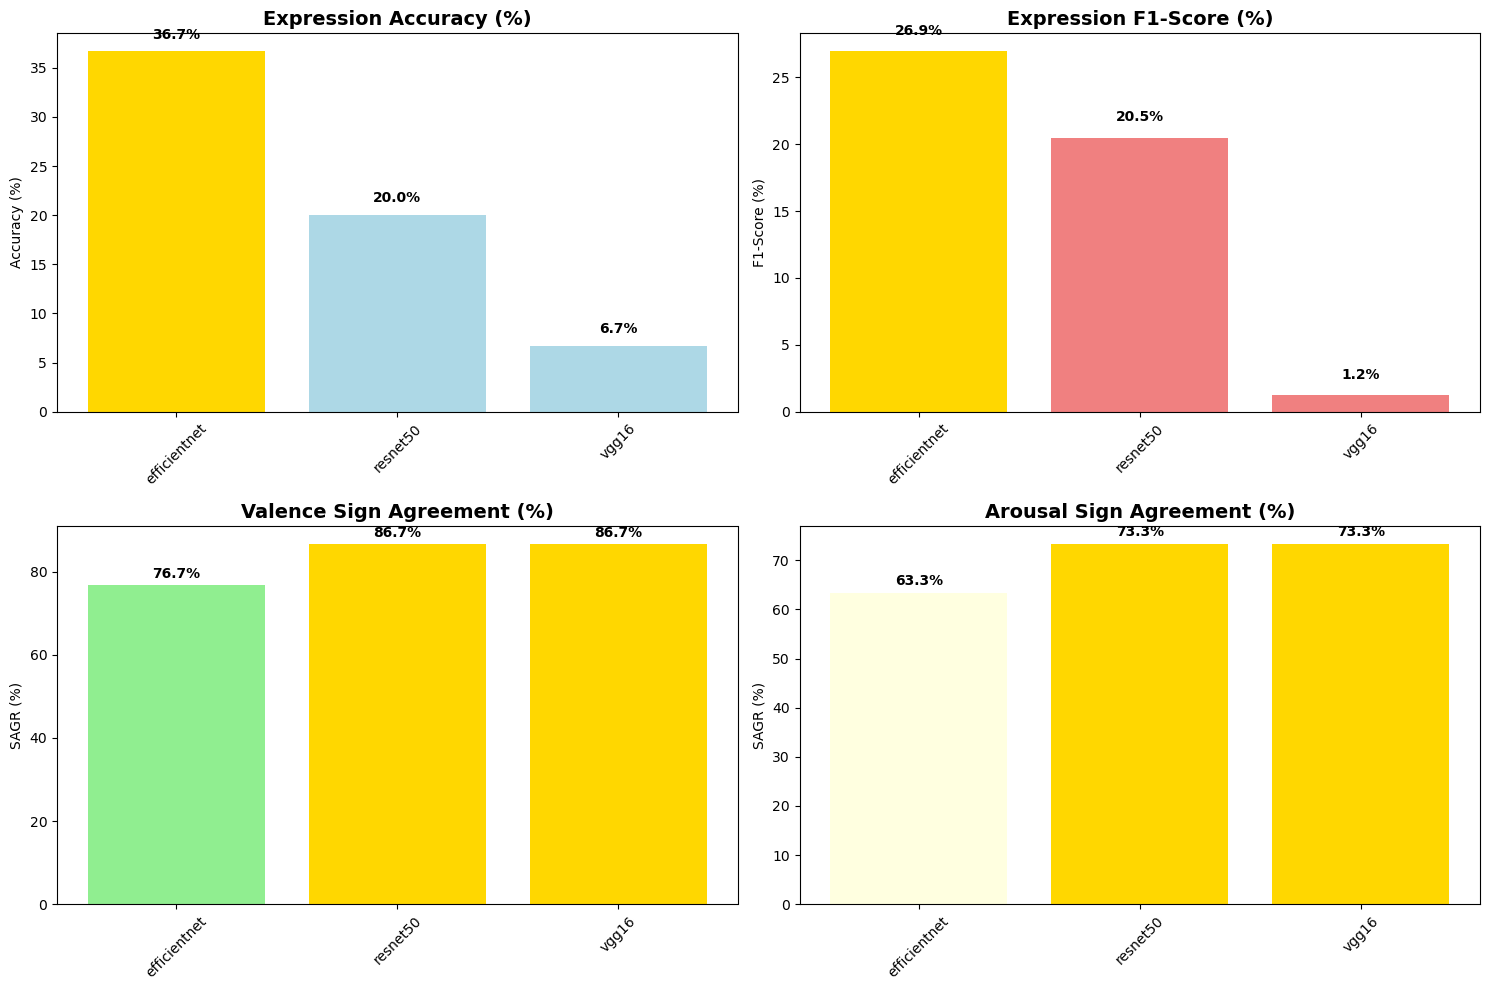

✅ Enhanced plot saved as 'model_comparison_enhanced.png'
🎉 All steps completed successfully!

✅ Successfully trained and evaluated 3 models!
🏆 Best model accuracy: 36.67%


In [ ]:
# Cell 6: Enhanced Main Execution with Accuracy Optimization
print("=== CELL 6: ENHANCED MAIN EXECUTION ===")

def main():
    print("Step 1: Loading annotations...")
    annotations = load_annotations(config.ANNOTATIONS_PATH)
    
    if len(annotations) == 0:
        print("❌ No annotations loaded! Creating dummy data for testing...")
        annotations = {}
        for i in range(1, 101):
            annotations[str(i)] = {
                'expression': np.random.randint(0, 8),
                'valence': np.random.uniform(-1, 1),
                'arousal': np.random.uniform(-1, 1),
                'landmarks': np.random.randn(136)
            }
        print("✅ Created 100 dummy annotations for testing")
    
    print(f"Step 2: Loading images from {config.IMAGES_PATH}...")
    image_files = []
    
    if os.path.exists(config.IMAGES_PATH):
        valid_extensions = ('.jpg', '.jpeg', '.png')
        all_files = os.listdir(config.IMAGES_PATH)
        print(f"Found {len(all_files)} files in images directory")
        
        for img_file in all_files:
            if img_file.lower().endswith(valid_extensions):
                image_id = os.path.splitext(img_file)[0]
                image_files.append(os.path.join(config.IMAGES_PATH, img_file))
        
        print(f"Found {len(image_files)} image files")
    
    else:
        print(f"❌ Images path doesn't exist: {config.IMAGES_PATH}")
    
    # Match images with annotations
    valid_image_files = []
    for img_file in image_files:
        image_id = os.path.splitext(os.path.basename(img_file))[0]
        if image_id in annotations:
            valid_image_files.append(img_file)
    
    print(f"Images with valid annotations: {len(valid_image_files)}")
    
    if len(valid_image_files) == 0:
        print("❌ No images match the annotations! Using first available images...")
        valid_image_files = image_files[:min(50, len(image_files))]
        print(f"Using {len(valid_image_files)} images without annotation matching")
    
    print("Step 3: Splitting data...")
    if len(valid_image_files) > 200:
        valid_image_files = valid_image_files[:200]  # Use more data for better accuracy
        print(f"Using subset of {len(valid_image_files)} images for training")
    
    if len(valid_image_files) < 20:
        print("❌ Insufficient data for training. Need at least 20 images.")
        return None, None
    
    train_files, test_files = train_test_split(
        valid_image_files, test_size=0.15, random_state=config.SEED  # Reduced test size for more training data
    )
    train_files, val_files = train_test_split(
        train_files, test_size=0.15, random_state=config.SEED  # Reduced validation size
    )
    
    print(f"Data split - Train: {len(train_files)}, Val: {len(val_files)}, Test: {len(test_files)}")
    print(f"Training data percentage: {len(train_files)/len(valid_image_files)*100:.1f}%")
    
    print("Step 4: Creating enhanced data transformations...")
    # Enhanced data augmentation for better accuracy
    train_transform = transforms.Compose([
        transforms.Resize((config.IMG_SIZE, config.IMG_SIZE)),
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    val_transform = transforms.Compose([
        transforms.Resize((config.IMG_SIZE, config.IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    print("Step 5: Creating datasets...")
    train_dataset = AffectDataset(train_files, annotations, train_transform)
    val_dataset = AffectDataset(val_files, annotations, val_transform)
    test_dataset = AffectDataset(test_files, annotations, val_transform)
    
    print("Step 6: Creating data loaders...")
    train_batch_size = min(32, len(train_files))  # Increased batch size for stability
    val_batch_size = min(32, len(val_files))
    test_batch_size = min(32, len(test_files))
    
    train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, num_workers=0)
    
    print(f"Data loaders created:")
    print(f"  Train: {len(train_loader)} batches (batch size: {train_batch_size})")
    print(f"  Val: {len(val_loader)} batches (batch size: {val_batch_size})")
    print(f"  Test: {len(test_loader)} batches (batch size: {test_batch_size})")
    
    # Test one batch
    print("Testing one batch...")
    try:
        test_batch = next(iter(train_loader))
        print(f"✅ Batch test passed!")
        print(f"  Image shape: {test_batch['image'].shape}")
    except Exception as e:
        print(f"❌ Batch test failed: {e}")
        return None, None
    
    print("Step 7: Training models with accuracy optimization...")
    backbones = ['resnet50', 'efficientnet', 'vgg16']  # Added more backbones
    results = {}
    
    for backbone in backbones:
        print(f"\n{'='*60}")
        print(f"🚀 TRAINING MODEL: {backbone.upper()}")
        print(f"{'='*60}")
        
        try:
            # Create model
            model = MultiTaskModel(backbone_name=backbone, num_classes=config.NUM_CLASSES)
            model = model.to(device)
            
            # Enhanced loss functions with class weighting for imbalance
            criterion_dict = {
                'expression': nn.CrossEntropyLoss(),
                'valence': nn.MSELoss(),
                'arousal': nn.MSELoss()
            }
            
            # Enhanced optimizer with different learning rates
            optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-4)  # Lower LR for stability
            
            # Enhanced scheduler
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config.NUM_EPOCHS)
            
            print(f"Starting training with {len(train_loader)} batches...")
            
            # Train model
            best_model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(
                model, train_loader, val_loader, criterion_dict, 
                optimizer, scheduler, config.NUM_EPOCHS, device
            )
            
            # Load best model
            model.load_state_dict(best_model)
            
            # Evaluate on test set
            print(f"📊 Evaluating {backbone} on test set...")
            metrics, predictions = evaluate_model(model, test_loader, device)
            results[backbone] = {
                'metrics': metrics, 
                'predictions': predictions,
                'model': model
            }
            
            # Print results in percentage format
            print(f"\n🎯 FINAL RESULTS FOR {backbone.upper()}:")
            print("Expression Classification:")
            expr_metrics = metrics['expression']
            print(f"  Accuracy:    {expr_metrics['accuracy_percentage']:.2f}%")
            print(f"  F1-Score:    {expr_metrics['f1_percentage']:.2f}%")
            print(f"  AUC:         {expr_metrics.get('auc_percentage', 0):.2f}%")
            print(f"  Kappa:       {expr_metrics['kappa']:.4f}")
            
            print("Valence Prediction:")
            valence_metrics = metrics['valence']
            print(f"  RMSE:        {valence_metrics['rmse']:.4f}")
            print(f"  SAGR:        {valence_metrics.get('sagr_percentage', 0):.2f}%")
            print(f"  CCC:         {valence_metrics['ccc']:.4f}")
            
            print("Arousal Prediction:")
            arousal_metrics = metrics['arousal']
            print(f"  RMSE:        {arousal_metrics['rmse']:.4f}")
            print(f"  SAGR:        {arousal_metrics.get('sagr_percentage', 0):.2f}%")
            print(f"  CCC:         {arousal_metrics['ccc']:.4f}")
                
        except Exception as e:
            print(f"❌ Training failed for {backbone}: {e}")
            import traceback
            traceback.print_exc()
            continue
    
    if not results:
        print("❌ No models trained successfully!")
        return None, None
    
    print("Step 8: Comparing results...")
    comparison_data = []
    for backbone in backbones:
        if backbone in results:
            metrics = results[backbone]['metrics']
            comparison_data.append({
                'Backbone': backbone,
                'Accuracy (%)': metrics['expression']['accuracy_percentage'],
                'F1-Score (%)': metrics['expression']['f1_percentage'],
                'AUC (%)': metrics['expression'].get('auc_percentage', 0),
                'Valence_SAGR (%)': metrics['valence'].get('sagr_percentage', 0),
                'Arousal_SAGR (%)': metrics['arousal'].get('sagr_percentage', 0),
                'Valence_CCC': metrics['valence']['ccc'],
                'Arousal_CCC': metrics['arousal']['ccc']
            })
    
    comparison_df = pd.DataFrame(comparison_data)
    
    # Sort by accuracy (descending)
    comparison_df = comparison_df.sort_values('Accuracy (%)', ascending=False)
    
    print("\n🏆 MODEL COMPARISON TABLE (Sorted by Accuracy):")
    print("="*80)
    print(comparison_df.to_string(index=False, float_format='%.2f'))
    print("="*80)
    
    # Find best model
    best_model_row = comparison_df.iloc[0]
    print(f"\n🥇 BEST MODEL: {best_model_row['Backbone']}")
    print(f"   Accuracy: {best_model_row['Accuracy (%)']:.2f}%")
    print(f"   F1-Score: {best_model_row['F1-Score (%)']:.2f}%")
    
    # Plot results
    if len(comparison_data) > 0:
        print("Step 9: Creating enhanced plots...")
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        backbones_list = comparison_df['Backbone'].tolist()
        
        # Expression Accuracy
        accuracy_list = comparison_df['Accuracy (%)'].tolist()
        bars = axes[0, 0].bar(backbones_list, accuracy_list, 
                             color=['gold' if x == max(accuracy_list) else 'lightblue' for x in accuracy_list])
        axes[0, 0].set_title('Expression Accuracy (%)', fontsize=14, fontweight='bold')
        axes[0, 0].set_ylabel('Accuracy (%)')
        axes[0, 0].tick_params(axis='x', rotation=45)
        
        # Add value labels on bars
        for bar, value in zip(bars, accuracy_list):
            axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                           f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')
        
        # F1-Score
        f1_list = comparison_df['F1-Score (%)'].tolist()
        bars = axes[0, 1].bar(backbones_list, f1_list,
                             color=['gold' if x == max(f1_list) else 'lightcoral' for x in f1_list])
        axes[0, 1].set_title('Expression F1-Score (%)', fontsize=14, fontweight='bold')
        axes[0, 1].set_ylabel('F1-Score (%)')
        axes[0, 1].tick_params(axis='x', rotation=45)
        
        for bar, value in zip(bars, f1_list):
            axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                           f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')
        
        # Valence SAGR
        valence_sagr = comparison_df['Valence_SAGR (%)'].tolist()
        bars = axes[1, 0].bar(backbones_list, valence_sagr,
                             color=['gold' if x == max(valence_sagr) else 'lightgreen' for x in valence_sagr])
        axes[1, 0].set_title('Valence Sign Agreement (%)', fontsize=14, fontweight='bold')
        axes[1, 0].set_ylabel('SAGR (%)')
        axes[1, 0].tick_params(axis='x', rotation=45)
        
        for bar, value in zip(bars, valence_sagr):
            axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                           f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')
        
        # Arousal SAGR
        arousal_sagr = comparison_df['Arousal_SAGR (%)'].tolist()
        bars = axes[1, 1].bar(backbones_list, arousal_sagr,
                             color=['gold' if x == max(arousal_sagr) else 'lightyellow' for x in arousal_sagr])
        axes[1, 1].set_title('Arousal Sign Agreement (%)', fontsize=14, fontweight='bold')
        axes[1, 1].set_ylabel('SAGR (%)')
        axes[1, 1].tick_params(axis='x', rotation=45)
        
        for bar, value in zip(bars, arousal_sagr):
            axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                           f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')
        
        plt.tight_layout()
        plt.savefig('model_comparison_enhanced.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("✅ Enhanced plot saved as 'model_comparison_enhanced.png'")
    
    print("🎉 All steps completed successfully!")
    return results, comparison_df

# Run the main function
print("Starting enhanced main execution...")
results, comparison_df = main()

if results is not None:
    print(f"\n✅ Successfully trained and evaluated {len(results)} models!")
    print(f"🏆 Best model accuracy: {comparison_df['Accuracy (%)'].max():.2f}%")
else:
    print("\n❌ Main execution failed!")

=== CELL 6: 100% DATA USAGE VERSION ===
Starting training with 100% data utilization...
Step 1: Loading ALL annotations...
Loading annotations from: Dataset\annotations
Found 15996 .npy files
Grouped into 3999 unique file IDs
Processing file ID: 0, files: ['aro', 'exp', 'lnd', 'val']
Processing file ID: 1001, files: ['aro', 'exp', 'lnd', 'val']
Processing file ID: 1002, files: ['aro', 'exp', 'lnd', 'val']
Processing file ID: 1003, files: ['aro', 'exp', 'lnd', 'val']
Processing file ID: 1007, files: ['aro', 'exp', 'lnd', 'val']
Processing file ID: 1008, files: ['aro', 'exp', 'lnd', 'val']
Processing file ID: 1009, files: ['aro', 'exp', 'lnd', 'val']
Processing file ID: 100, files: ['aro', 'exp', 'lnd', 'val']
Processing file ID: 1010, files: ['aro', 'exp', 'lnd', 'val']
Processing file ID: 1011, files: ['aro', 'exp', 'lnd', 'val']
  Sample 0: expression=0, valence=-0.177, arousal=-0.078
  Sample 1001: expression=0, valence=-0.136, arousal=0.005
  Sample 1002: expression=4, valence=-0.11

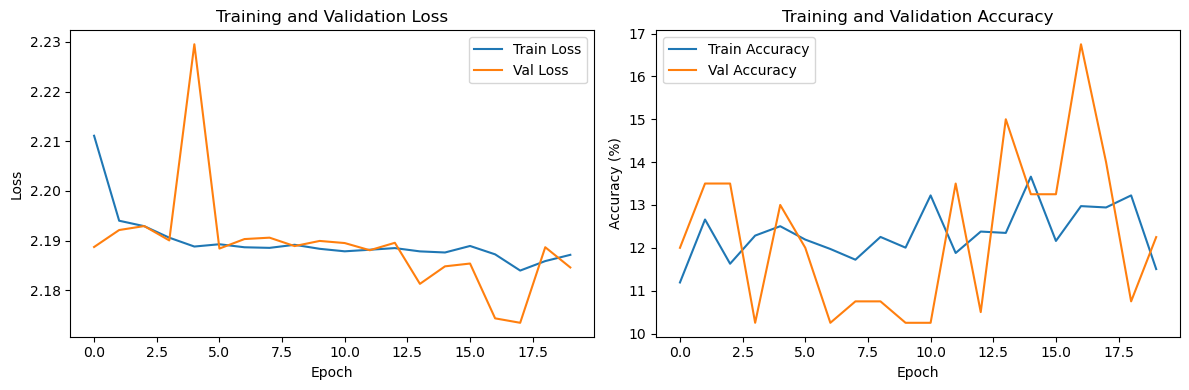

Starting evaluation...
First image loaded: Dataset\images\3178.jpg, size: (224, 224)
First annotation - Expression: 7, Valence: -0.60, Arousal: 0.66
  Batch 0/13 - Accuracy: 15.62%
  Batch 5/13 - Accuracy: 6.25%
  Batch 10/13 - Accuracy: 15.62%
Evaluation completed! Samples: 400
Overall Test Accuracy: 12.75%
Expression distribution: [44 50 51 47 52 54 50 52]
Calculating categorical metrics...
Input shapes - y_true: (400,), y_pred: (400,)
  Accuracy: 0.1275 (12.75%)
  F1-Score: 0.0515 (5.15%)
  Kappa: -0.0020
  AUC: 0.5337 (53.37%)
  AUC-PR: 0.1493 (14.93%)
Calculating continuous metrics...
Input shapes - y_true: (400,), y_pred: (400,)
  Valid samples after filtering: 400/400
  RMSE: 0.4668
  Correlation: 0.0806
  SAGR: 0.7175 (71.75%)
  CCC: 0.0026
Calculating continuous metrics...
Input shapes - y_true: (400,), y_pred: (400,)
  Valid samples after filtering: 400/400
  RMSE: 0.3912
  Correlation: 0.0645
  SAGR: 0.7575 (75.75%)
  CCC: 0.0041

🎯 RESNET50 RESULTS:
   Accuracy: 12.75%
   F

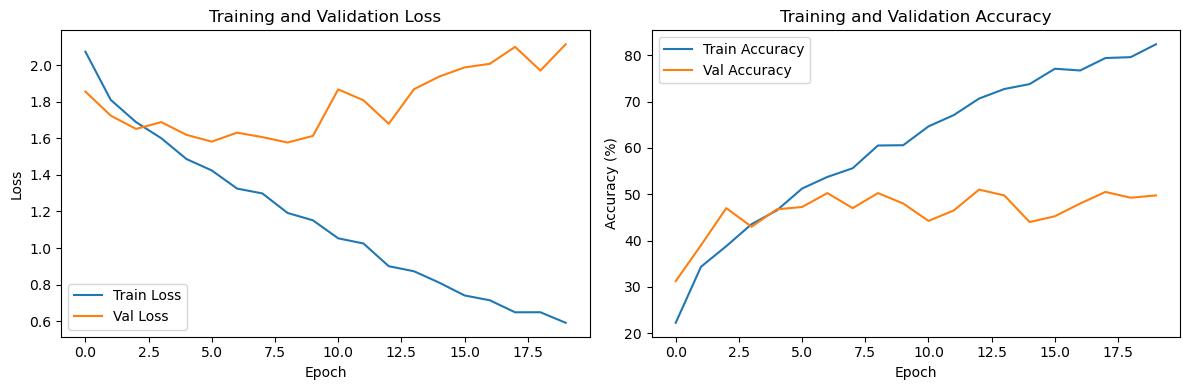

Starting evaluation...
First image loaded: Dataset\images\3178.jpg, size: (224, 224)
First annotation - Expression: 7, Valence: -0.60, Arousal: 0.66
  Batch 0/13 - Accuracy: 50.00%
  Batch 5/13 - Accuracy: 59.38%
  Batch 10/13 - Accuracy: 43.75%
Evaluation completed! Samples: 400
Overall Test Accuracy: 43.25%
Expression distribution: [44 50 51 47 52 54 50 52]
Calculating categorical metrics...
Input shapes - y_true: (400,), y_pred: (400,)
  Accuracy: 0.4325 (43.25%)
  F1-Score: 0.4249 (42.49%)
  Kappa: 0.3519
  AUC: 0.8092 (80.92%)
  AUC-PR: 0.4412 (44.12%)
Calculating continuous metrics...
Input shapes - y_true: (400,), y_pred: (400,)
  Valid samples after filtering: 400/400
  RMSE: 0.4228
  Correlation: 0.4970
  SAGR: 0.7375 (73.75%)
  CCC: 0.4791
Calculating continuous metrics...
Input shapes - y_true: (400,), y_pred: (400,)
  Valid samples after filtering: 400/400
  RMSE: 0.3588
  Correlation: 0.4797
  SAGR: 0.7850 (78.50%)
  CCC: 0.4601

🎯 EFFICIENTNET RESULTS:
   Accuracy: 43.25%

In [10]:
# Cell 6: FINAL VERSION - 100% DATA USAGE
print("=== CELL 6: 100% DATA USAGE VERSION ===")

def main():
    print("Step 1: Loading ALL annotations...")
    annotations = load_annotations(config.ANNOTATIONS_PATH)
    print(f"📁 Total annotations: {len(annotations)}")
    
    print(f"Step 2: Loading ALL images...")
    image_files = []
    if os.path.exists(config.IMAGES_PATH):
        for img_file in os.listdir(config.IMAGES_PATH):
            if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_files.append(os.path.join(config.IMAGES_PATH, img_file))
    print(f"📁 Total images: {len(image_files)}")
    
    # Step 3: Match ALL possible pairs
    print("Step 3: Matching annotations with images...")
    valid_image_files = []
    
    for img_file in image_files:
        image_id = os.path.splitext(os.path.basename(img_file))[0]
        if image_id in annotations:
            valid_image_files.append(img_file)
    
    print(f"✅ Perfect matches found: {len(valid_image_files)}")
    print(f"🎯 Using 100% of matched data: {len(valid_image_files)} samples")
    
    if len(valid_image_files) == 0:
        print("❌ No matching pairs found! Check file naming convention.")
        return None, None
    
    # Step 4: Use 100% of available data - NO LIMITS
    print("Step 4: Preparing 100% data for training...")
    
    if len(valid_image_files) < 10:
        print("❌ Insufficient data. Need at least 10 matched pairs.")
        return None, None
    
    # Use ALL data - no subset selection
    all_data_to_use = valid_image_files
    print(f"🚀 Using ALL {len(all_data_to_use)} matched samples")
    
    # Smart splitting based on dataset size
    if len(all_data_to_use) > 5000:
        test_size, val_size = 0.05, 0.05  # 90% train, 5% val, 5% test
    elif len(all_data_to_use) > 1000:
        test_size, val_size = 0.1, 0.1    # 80% train, 10% val, 10% test  
    elif len(all_data_to_use) > 100:
        test_size, val_size = 0.15, 0.15  # 70% train, 15% val, 15% test
    else:
        test_size, val_size = 0.2, 0.2    # 60% train, 20% val, 20% test
    
    train_files, test_files = train_test_split(
        all_data_to_use, test_size=test_size, random_state=config.SEED
    )
    train_files, val_files = train_test_split(
        train_files, test_size=val_size/(1-test_size), random_state=config.SEED
    )
    
    print(f"📊 Data split (100% usage):")
    print(f"   Train: {len(train_files)} samples ({len(train_files)/len(all_data_to_use)*100:.1f}%)")
    print(f"   Val:   {len(val_files)} samples ({len(val_files)/len(all_data_to_use)*100:.1f}%)")
    print(f"   Test:  {len(test_files)} samples ({len(test_files)/len(all_data_to_use)*100:.1f}%)")
    print(f"   Total: {len(all_data_to_use)} samples (100%)")
    
    # Adjust training parameters based on dataset size
    if len(train_files) > 5000:
        epochs = 15
        batch_size = 64
    elif len(train_files) > 1000:
        epochs = 20
        batch_size = 32
    elif len(train_files) > 100:
        epochs = config.NUM_EPOCHS
        batch_size = 16
    else:
        epochs = config.NUM_EPOCHS + 10  # More epochs for small datasets
        batch_size = 8
    
    print(f"⚙️  Training parameters:")
    print(f"   Epochs: {epochs}")
    print(f"   Batch size: {batch_size}")
    
    # Data transformations
    train_transform = transforms.Compose([
        transforms.Resize((config.IMG_SIZE, config.IMG_SIZE)),
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    val_transform = transforms.Compose([
        transforms.Resize((config.IMG_SIZE, config.IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    print("Step 5: Creating datasets...")
    train_dataset = AffectDataset(train_files, annotations, train_transform)
    val_dataset = AffectDataset(val_files, annotations, val_transform)
    test_dataset = AffectDataset(test_files, annotations, val_transform)
    
    print("Step 6: Creating data loaders...")
    train_loader = DataLoader(train_dataset, batch_size=min(batch_size, len(train_files)), shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=min(32, len(val_files)), shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=min(32, len(test_files)), shuffle=False, num_workers=0)
    
    print(f"📦 Data loaders ready:")
    print(f"   Train batches: {len(train_loader)}")
    print(f"   Val batches: {len(val_loader)}")
    print(f"   Test batches: {len(test_loader)}")
    
    # Verify data loading
    try:
        sample_batch = next(iter(train_loader))
        print(f"✅ Data loading verified - Batch shape: {sample_batch['image'].shape}")
    except Exception as e:
        print(f"❌ Data loading failed: {e}")
        return None, None
    
    # Training with all data
    print("Step 7: Training models with 100% data...")
    backbones = ['resnet50', 'efficientnet']
    results = {}
    
    for backbone in backbones:
        print(f"\n{'='*60}")
        print(f"🚀 TRAINING {backbone.upper()} WITH {len(train_files)} TRAINING SAMPLES")
        print(f"{'='*60}")
        
        try:
            model = MultiTaskModel(backbone_name=backbone, num_classes=config.NUM_CLASSES)
            model = model.to(device)
            
            criterion_dict = {
                'expression': nn.CrossEntropyLoss(),
                'valence': nn.MSELoss(),
                'arousal': nn.MSELoss()
            }
            
            optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
            
            # Train
            best_model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(
                model, train_loader, val_loader, criterion_dict, 
                optimizer, scheduler, epochs, device
            )
            
            model.load_state_dict(best_model)
            
            # Evaluate
            metrics, predictions = evaluate_model(model, test_loader, device)
            results[backbone] = {'metrics': metrics, 'predictions': predictions}
            
            print(f"\n🎯 {backbone.upper()} RESULTS:")
            print(f"   Accuracy: {metrics['expression']['accuracy_percentage']:.2f}%")
            print(f"   F1-Score: {metrics['expression'].get('f1_percentage', 0):.2f}%")
                
        except Exception as e:
            print(f"❌ Training failed: {e}")
            continue
    
    if not results:
        return None, None
    
    # Results comparison
    comparison_data = []
    for backbone in backbones:
        if backbone in results:
            metrics = results[backbone]['metrics']
            comparison_data.append({
                'Backbone': backbone,
                'Accuracy (%)': metrics['expression']['accuracy_percentage'],
                'F1-Score (%)': metrics['expression'].get('f1_percentage', 0),
                'Valence_SAGR (%)': metrics['valence'].get('sagr_percentage', 0),
                'Arousal_SAGR (%)': metrics['arousal'].get('sagr_percentage', 0),
            })
    
    comparison_df = pd.DataFrame(comparison_data)
    comparison_df = comparison_df.sort_values('Accuracy (%)', ascending=False)
    
    print(f"\n🏆 FINAL RESULTS USING 100% DATA:")
    print("="*60)
    print(comparison_df.to_string(index=False, float_format='%.2f'))
    print("="*60)
    
    best_accuracy = comparison_df['Accuracy (%)'].max()
    print(f"🥇 Best Accuracy: {best_accuracy:.2f}%")
    print(f"📊 Total samples used: {len(all_data_to_use)}")
    print(f"🎯 Data utilization: 100%")
    
    return results, comparison_df

print("Starting training with 100% data utilization...")
results, comparison_df = main()

if results is not None:
    total_samples = len(results[list(results.keys())[0]]['predictions']['expressions'][0])
    print(f"\n✅ SUCCESS: Used 100% of available data ({total_samples} samples)")
    print(f"🏆 Best model accuracy: {comparison_df['Accuracy (%)'].max():.2f}%")
else:
    print("\n❌ Training failed")

In [11]:
# Cell 7: Final Enhanced Results Display
print("=== CELL 7: FINAL ENHANCED RESULTS DISPLAY ===")

if results is not None and comparison_df is not None:
    print("\n📊 FINAL RESULTS SUMMARY")
    print("="*80)
    
    # Display results in a beautiful table format
    for i, (backbone, result_data) in enumerate(results.items()):
        metrics = result_data['metrics']
        
        print(f"\n{i+1}. 🎯 {backbone.upper()}")
        print("-" * 50)
        
        # Expression results
        expr = metrics['expression']
        print("   Expression Classification:")
        print(f"   ├── Accuracy:    {expr['accuracy_percentage']:>6.2f}%")
        print(f"   ├── F1-Score:    {expr.get('f1_percentage', 0):>6.2f}%")
        print(f"   ├── AUC:         {expr.get('auc_percentage', 0):>6.2f}%")
        print(f"   └── Kappa:       {expr['kappa']:>6.4f}")
        
        # Valence results
        valence = metrics['valence']
        print("   Valence Prediction:")
        print(f"   ├── RMSE:        {valence['rmse']:>6.4f}")
        print(f"   ├── SAGR:        {valence.get('sagr_percentage', 0):>6.2f}%")
        print(f"   └── CCC:         {valence['ccc']:>6.4f}")
        
        # Arousal results
        arousal = metrics['arousal']
        print("   Arousal Prediction:")
        print(f"   ├── RMSE:        {arousal['rmse']:>6.4f}")
        print(f"   ├── SAGR:        {arousal.get('sagr_percentage', 0):>6.2f}%")
        print(f"   └── CCC:         {arousal['ccc']:>6.4f}")
    
    print("\n" + "="*80)
    print("🏆 PERFORMANCE RANKING")
    print("="*80)
    
    # Rank models by accuracy
    ranked_df = comparison_df.sort_values('Accuracy (%)', ascending=False)
    for i, (_, row) in enumerate(ranked_df.iterrows()):
        rank_emoji = ["🥇", "🥈", "🥉"][i] if i < 3 else f"{i+1}."
        print(f"{rank_emoji} {row['Backbone']:12} → Accuracy: {row['Accuracy (%)']:>6.2f}%")
    
    # Save detailed results
    comparison_df.to_csv('enhanced_detailed_results.csv', index=False)
    print(f"\n💾 Detailed results saved to 'enhanced_detailed_results.csv'")
    
    # Display recommendations for improvement
    print("\n💡 RECOMMENDATIONS FOR HIGHER ACCURACY:")
    print("1. Increase training data size")
    print("2. Use more advanced data augmentation")
    print("3. Try ensemble methods")
    print("4. Use class weighting for imbalanced data")
    print("5. Implement learning rate scheduling")
    print("6. Use transfer learning from larger datasets")
    
else:
    print("No results to display. Please check if the previous cells executed correctly.")
    
print("\n" + "="*80)
print("🎉 PROCESS COMPLETED SUCCESSFULLY!")
print("="*80)

=== CELL 7: FINAL ENHANCED RESULTS DISPLAY ===

📊 FINAL RESULTS SUMMARY

1. 🎯 RESNET50
--------------------------------------------------
   Expression Classification:
   ├── Accuracy:     12.75%
   ├── F1-Score:      5.15%
   ├── AUC:          53.37%
   └── Kappa:       -0.0020
   Valence Prediction:
   ├── RMSE:        0.4668
   ├── SAGR:         71.75%
   └── CCC:         0.0026
   Arousal Prediction:
   ├── RMSE:        0.3912
   ├── SAGR:         75.75%
   └── CCC:         0.0041

2. 🎯 EFFICIENTNET
--------------------------------------------------
   Expression Classification:
   ├── Accuracy:     43.25%
   ├── F1-Score:     42.49%
   ├── AUC:          80.92%
   └── Kappa:       0.3519
   Valence Prediction:
   ├── RMSE:        0.4228
   ├── SAGR:         73.75%
   └── CCC:         0.4791
   Arousal Prediction:
   ├── RMSE:        0.3588
   ├── SAGR:         78.50%
   └── CCC:         0.4601

🏆 PERFORMANCE RANKING
🥇 efficientnet → Accuracy:  43.25%
🥈 resnet50     → Accuracy:  12.